In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import sys
sys.path.append('./modelos')

from lg import LogisticRegressionBinary, LogisticRegressionMulticlass

In [2]:
loc = "./Premier-League/"

teams = pd.read_csv(loc + "EPLStandindsFinal.csv")["Team"]
print(teams[25])

dataset = pd.read_csv(loc + "premier_league2001-2021.csv")
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset.info()


Man City
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7980 entries, 0 to 7979
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7980 non-null   datetime64[ns]
 1   HomeTeam       7980 non-null   object        
 2   AwayTeam       7980 non-null   object        
 3   FTHG           7980 non-null   int64         
 4   FTAG           7980 non-null   int64         
 5   FTR            7980 non-null   object        
 6   HTGS           7980 non-null   int64         
 7   ATGS           7980 non-null   int64         
 8   HTGC           7980 non-null   int64         
 9   ATGC           7980 non-null   int64         
 10  HTP            7980 non-null   float64       
 11  ATP            7980 non-null   float64       
 12  HM1            7980 non-null   object        
 13  HM2            7980 non-null   object        
 14  HM3            7980 non-null   object        
 15  HM4         

In [3]:
datasetParsed = dataset.drop(dataset.loc[(dataset["MW"] == 1)  | (dataset["MW"] == 2) | (dataset["MW"] == 3)].index)
datasetParsed

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTGS,ATGS,HTGC,ATGC,...,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,HTGD,ATGD,DiffPts,DiffFormPts,DiffFormPts3,DiffLP
30,2000-09-05,Man United,Bradford,6,0,H,5,2,3,1,...,0,0,0,0,0.500000,0.250000,0.250000,1,1,-16.0
31,2000-09-05,Sunderland,West Ham,1,1,D,3,4,5,7,...,0,0,0,0,-0.500000,-0.750000,0.500000,2,2,-2.0
32,2000-09-05,Tottenham,Everton,3,2,H,4,5,4,4,...,0,0,0,0,0.000000,0.250000,0.000000,0,0,-3.0
33,2000-09-06,Charlton,Southampton,1,1,D,7,6,8,7,...,0,0,0,0,-0.250000,-0.250000,0.250000,1,1,3.0
34,2000-09-06,Chelsea,Arsenal,2,2,D,5,7,5,4,...,0,0,0,0,0.000000,0.750000,-0.500000,-2,-2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7975,2021-05-23,Liverpool,Crystal Palace,2,0,H,66,41,42,64,...,0,0,0,0,0.631579,-0.605263,0.578947,7,6,-13.0
7976,2021-05-23,Man City,Everton,5,0,H,78,47,32,43,...,0,0,0,0,1.210526,0.105263,0.631579,2,-1,-10.0
7977,2021-05-23,Sheffield United,Burnley,1,0,H,19,33,63,54,...,0,0,0,0,-1.157895,-0.552632,-0.500000,0,0,-1.0
7978,2021-05-23,West Ham,Southampton,3,0,H,59,47,47,65,...,0,0,0,0,0.315789,-0.473684,0.500000,0,-2,5.0


In [4]:
selectedColumns = ["Date","DiffLP", "DiffPts", "DiffFormPts3",  # Diferenças
                    "HTWinStreak3", "ATWinStreak3","HTLossStreak3", "ATLossStreak3", # Streaks
                    "HTGS", "ATGS", "HTGC", "ATGC", # Gols Feitos e Recebidos de cada um
                    "HTFormPts3", "ATFormPts3", # Pontos ganhos nas últimas semanas
                    "HTGD", "ATGD", "HomeTeamLP", "AwayTeamLP", # Diferença de Gol
                    "HM1","HM2","HM3","AM1","AM2","AM3", # Resultado dos últimos 3 jogos
                    "HSA", "ASA", "HSTA", "ASTA", "FTR"] # Chutes e Chutes a Gol
    
datasetSelected = datasetParsed[selectedColumns]
datasetSelected

,Date,DiffLP,DiffPts,DiffFormPts3,HTWinStreak3,ATWinStreak3,HTLossStreak3,ATLossStreak3,HTGS,ATGS,...,HM2,HM3,AM1,AM2,AM3,HSA,ASA,HSTA,ASTA,FTR
30,2000-09-05,-16.0,0.250000,1,0,0,0,0,5,2,...,D,W,D,W,L,42,23,20,9,H
31,2000-09-05,-2.0,0.500000,2,0,0,0,0,3,4,...,L,W,D,L,L,26,46,9,25,D
32,2000-09-05,-3.0,0.000000,0,0,0,0,0,4,5,...,D,W,D,W,L,41,37,12,23,H
33,2000-09-06,3.0,0.250000,1,0,0,0,0,7,6,...,L,W,D,L,D,32,39,22,17,D
34,2000-09-06,3.0,-0.500000,-2,0,0,0,0,5,7,...,L,W,W,W,L,42,49,23,28,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7975,2021-05-23,-13.0,0.578947,6,1,0,0,0,66,41,...,W,W,L,W,L,589,344,209,127,H
7976,2021-05-23,-10.0,0.631579,-1,0,0,0,0,78,47,...,W,L,W,L,D,583,392,208,145,H
7977,2021-05-23,-1.0,-0.500000,0,0,0,0,0,19,33,...,W,L,L,L,W,313,374,96,127,H
7978,2021-05-23,5.0,0.500000,-2,0,0,0,0,59,47,...,D,L,L,W,W,454,406,158,161,H


In [5]:
columns_to_encode = ["HM1", "HM2", "HM3", "AM1", "AM2", "AM3"] 
# Para fazer o OneHotEncoding das variáveis HM e AM

# Realiza o one-hot encoding nas colunas selecionadas
datasetSelected_encoded = pd.get_dummies(datasetSelected, columns=columns_to_encode)

datasetSelected_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7350 entries, 30 to 7979
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7350 non-null   datetime64[ns]
 1   DiffLP         7350 non-null   float64       
 2   DiffPts        7350 non-null   float64       
 3   DiffFormPts3   7350 non-null   int64         
 4   HTWinStreak3   7350 non-null   int64         
 5   ATWinStreak3   7350 non-null   int64         
 6   HTLossStreak3  7350 non-null   int64         
 7   ATLossStreak3  7350 non-null   int64         
 8   HTGS           7350 non-null   int64         
 9   ATGS           7350 non-null   int64         
 10  HTGC           7350 non-null   int64         
 11  ATGC           7350 non-null   int64         
 12  HTFormPts3     7350 non-null   int64         
 13  ATFormPts3     7350 non-null   int64         
 14  HTGD           7350 non-null   float64       
 15  ATGD           7350 non-n

In [6]:
train = datasetSelected_encoded.loc[
                datasetSelected_encoded["Date"] < "2015-08-11"].sample(frac = 1, random_state = 42)

test = datasetSelected_encoded.loc[
                datasetSelected_encoded["Date"] >= "2015-08-11"].sample(frac = 1, random_state = 42)

print(train.shape)
print(test.shape)

(5250, 41)
(2100, 41)


In [7]:
y_train_multiclass = train["FTR"].astype("category").cat.codes
y_test_multiclass = test["FTR"].astype("category").cat.codes
y_train_binary = (train["FTR"] == "H").astype("int")
y_test_binary = (test["FTR"] == "H").astype("int")

x_train = pd.DataFrame(np.array(train.drop(["FTR", "Date"], axis = 1)))
x_test = np.array(test.drop(["FTR", "Date"], axis = 1))

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [8]:
logistical_regression_multiclass = LogisticRegressionMulticlass()

logistical_regression_multiclass.train_validation(x_train_scaled, y_train_multiclass, max_iter=1000)

acc, prec, f1, cm = logistical_regression_multiclass.test(x_test_scaled, y_test_multiclass)

print("Acurácia:", acc)
print("Precisão:", prec)
print("F1-Score:", f1)

Acurácia: 0.6719047619047619
Precisão: 0.6473922902494331
F1-Score: 0.6237028945931186


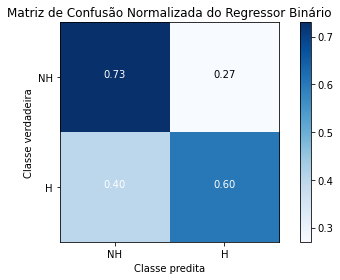

In [ ]:
logistical_regression = LogisticRegressionBinary()

logistical_regression.train_validation(x_train_scaled, y_train_binary, max_iter=1000)

acc, prec, f1, cm = logistical_regression.test(x_test_scaled, y_test_binary)

print("Acurácia:", acc)
print("Precisão:", prec)
print("F1-Score:", f1)